## Reading this section

Read in numerical order. The appendix contains additional data used in the assessment such as shell scripts and other useful files. 

## Preparing our data in Python for use in Neural Networks.

For use in Neural Networks we first need to pre-process our data into a suitable format for use with the Tensorflow package in order to compile and fit a Neural Network on our data that classifies attacks.

Throughout the report you will find similar methods used for each different network type that we attempted to implement, in order to achieve more consistent results, and these data processing techniques were shared amongst the group. The most important step is when we split the data for training and testing, where those of us using python made sure to specify the same `random_state` variable in order to produce the same data splitting.

We also each recreate these steps as we would send most of this processing off in our `.py` File that we submit to the HPC in order to avoid package discrepancy issues. At first I tried to save my training and testing data as pickle files, before copying them to the HPC and then accessing them with a Python script. Unfortunately due to discrepancies in the versions of Python packages this proved to be more trouble than it was worth and a lot of this data processing was then ported to the final Python script I submitted to the HPC.

We start by importing important packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import squarify
import tensorflow as tf
from tensorflow.keras import layers
import sklearn
from sklearn.model_selection import train_test_split
import pickle
import gzip
from urllib.request import urlopen

Now we import our data from the repository, saved in ZIP format in the GitHub respository to save space. These are split in 4 as the original data was.

In [2]:
start = dt.datetime.now()
print("Reading df1")
df1 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS1.zip",header=None)
print("Reading df2")
df2 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS2.zip",header=None)
print("Reading df3")
df3 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS3.zip",header=None)
print("Reading df4")
df4 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS4.zip",header=None)
print("Data fetched in:" ,dt.datetime.now()-start)

Reading df1


G:\Programs\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Reading df2


G:\Programs\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Reading df3
Reading df4
Data fetched in: 0:00:42.598074


We now concatenate the data frames (ignoring index in order to avoide any issues that may arise with duplicate indexes) and then add column names to the data. These columns names are adapted from the information provided alongside the data set on it's website.

In [3]:
df = pd.concat([df1,df2,df3,df4],ignore_index=True)
df.columns = ['source_ip', 'source_port', 'dest_ip', 'dest_port', 'proto', 'state', 'duration', 'source_bytes', 'dest_bytes', 'source_ttl',
             'dest_ttl', 'source_loss', 'dest_loss', 'service', 'source_load', 'dest_load', 'source_pkts', 'dest_pkts', 'source_TP_win', 'dest_TP_win', 
             'source_tcp_bn', 'dest_tcp_bn', 'source_mean_sz', 'dest_mean_sz', 'trans_depth', 'res_bdy_len', 'source_jitter', 'dest_jitter', 'start_time',
             'last_time', 'source_int_pk_time', 'dest_int_pk_time', 'tcp_rtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'count_state_ttl', 
             'count_flw_http_mthd', 'is_ftp_login', 'count_ftp_cmd', 'count_srv_source', 'count_srv_dest', 'count_dest_ltm',
             'count_source_ltm', 'count_source_destport_ltm', 'count_dest_sourceport_ltm', 'counts_dest_source_ltm', 'attack_cat', 'Label']
df.head(10)

,source_ip,source_port,dest_ip,dest_port,proto,state,duration,source_bytes,dest_bytes,source_ttl,...,count_ftp_cmd,count_srv_source,count_srv_dest,count_dest_ltm,count_source_ltm,count_source_destport_ltm,count_dest_sourceport_ltm,counts_dest_source_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
5,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0
6,59.166.0.6,2142,149.171.126.4,53,udp,CON,0.001134,132,164,31,...,0,12,7,1,2,2,1,1,NaN,0
7,10.40.182.3,0,10.40.182.3,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,NaN,0
8,59.166.0.5,40726,149.171.126.6,53,udp,CON,0.001126,146,178,31,...,0,6,7,3,1,1,1,1,NaN,0
9,59.166.0.7,12660,149.171.126.4,53,udp,CON,0.001167,132,164,31,...,0,6,7,2,1,1,1,1,NaN,0


Next we are going to check some of the features in our data. We check the size of the data frame and then take horizontal slices of the data as it is impossible to view all 49 columns in one view.

In [4]:
df.shape

(2540047, 49)

In [5]:
df_1 = df.iloc[:,0:16]
df_2 = df.iloc[:,16:32]
df_3 = df.iloc[:,32:49]
df_1.head()

,source_ip,source_port,dest_ip,dest_port,proto,state,duration,source_bytes,dest_bytes,source_ttl,dest_ttl,source_loss,dest_loss,service,source_load,dest_load
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250


In [6]:
df_2.head()

,source_pkts,dest_pkts,source_TP_win,dest_TP_win,source_tcp_bn,dest_tcp_bn,source_mean_sz,dest_mean_sz,trans_depth,res_bdy_len,source_jitter,dest_jitter,start_time,last_time,source_int_pk_time,dest_int_pk_time
0,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000
1,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333
2,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000
3,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000
4,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000


In [7]:
df_3.head()

,tcp_rtt,synack,ackdat,is_sm_ips_ports,count_state_ttl,count_flw_http_mthd,is_ftp_login,count_ftp_cmd,count_srv_source,count_srv_dest,count_dest_ltm,count_source_ltm,count_source_destport_ltm,count_dest_sourceport_ltm,counts_dest_source_ltm,attack_cat,Label
0,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0


We briefly check that our slices are the size we expect them to be (same number of rows as main data frame, and columns add up to 49)

In [8]:
print("shape of 1st slice:")
print(df_1.shape)
print("shape of 2nd slice:")
print(df_2.shape)
print("shape of 3rd slice:")
print(df_3.shape)

shape of 1st slice:
(2540047, 16)
shape of 2nd slice:
(2540047, 16)
shape of 3rd slice:
(2540047, 17)


We will describe each slice to check for any anomalous data values such as `NaN` and `inf`.

In [9]:
df_1.describe()

,duration,source_bytes,dest_bytes,source_ttl,dest_ttl,source_loss,dest_loss,source_load,dest_load
count,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06
mean,6.587916e-01,4.339600e+03,3.642759e+04,6.278197e+01,3.076681e+01,5.163921e+00,1.632944e+01,3.695645e+07,2.450861e+06
std,1.392493e+01,5.640599e+04,1.610960e+05,7.462277e+01,4.285089e+01,2.251707e+01,5.659474e+01,1.186043e+08,4.224863e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.037000e-03,2.000000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,1.353963e+05,1.191594e+04
50%,1.586100e-02,1.470000e+03,1.820000e+03,3.100000e+01,2.900000e+01,3.000000e+00,4.000000e+00,5.893038e+05,5.893179e+05
75%,2.145545e-01,3.182000e+03,1.489400e+04,3.100000e+01,2.900000e+01,7.000000e+00,1.400000e+01,2.039923e+06,2.925974e+06
max,8.786638e+03,1.435577e+07,1.465753e+07,2.550000e+02,2.540000e+02,5.319000e+03,5.507000e+03,5.988000e+09,1.287619e+08


In [10]:
df_2.describe()

,source_pkts,dest_pkts,source_TP_win,dest_TP_win,source_tcp_bn,dest_tcp_bn,source_mean_sz,dest_mean_sz,trans_depth,res_bdy_len,source_jitter,dest_jitter,start_time,last_time,source_int_pk_time,dest_int_pk_time
count,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06
mean,3.328884e+01,4.272664e+01,1.500887e+02,1.497459e+02,1.261701e+09,1.261766e+09,1.242536e+02,2.766719e+02,8.325318e-02,4.242118e+03,1.589037e+03,7.300755e+02,1.423261e+09,1.423261e+09,1.933225e+02,7.882476e+01
std,7.628388e+01,1.215020e+02,1.254824e+02,1.255438e+02,1.422027e+09,1.422139e+09,1.519162e+02,3.356166e+02,3.500045e-01,4.750053e+04,1.691036e+04,3.438558e+03,1.134449e+06,1.134448e+06,2.779163e+03,1.433191e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421927e+09,1.421927e+09,0.000000e+00,0.000000e+00
25%,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,6.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421952e+09,1.421952e+09,9.000000e-03,6.000000e-03
50%,1.200000e+01,1.200000e+01,2.550000e+02,2.550000e+02,6.397250e+08,6.384172e+08,7.300000e+01,8.900000e+01,0.000000e+00,0.000000e+00,1.912490e+01,2.653561e+00,1.424227e+09,1.424227e+09,4.682620e-01,4.147550e-01
75%,4.400000e+01,4.200000e+01,2.550000e+02,2.550000e+02,2.467160e+09,2.469411e+09,1.320000e+02,5.650000e+02,0.000000e+00,0.000000e+00,4.137935e+02,6.350857e+01,1.424245e+09,1.424245e+09,7.351427e+00,6.202100e+00
max,1.064600e+04,1.101800e+04,2.550000e+02,2.550000e+02,4.294959e+09,4.294954e+09,1.504000e+03,1.500000e+03,1.720000e+02,6.558056e+06,1.483831e+06,7.812211e+05,1.424262e+09,1.424262e+09,8.437150e+04,5.948532e+04


In [11]:
df_3.describe()

,tcp_rtt,synack,ackdat,is_sm_ips_ports,count_state_ttl,count_flw_http_mthd,is_ftp_login,count_srv_source,count_srv_dest,count_dest_ltm,count_source_ltm,count_source_destport_ltm,count_dest_sourceport_ltm,counts_dest_source_ltm,Label
count,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,1.191902e+06,1.110168e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06
mean,6.180475e-03,3.287595e-03,2.892880e-03,1.651544e-03,2.611546e-01,2.345856e-01,3.969940e-02,9.206988e+00,8.988958e+00,6.439103e+00,6.900986e+00,4.642139e+00,3.592729e+00,6.845886e+00,1.264870e-01
std,4.615863e-02,2.593570e-02,2.394668e-02,4.060563e-02,6.830974e-01,7.940924e-01,1.996589e-01,1.083676e+01,1.082249e+01,8.162034e+00,8.205062e+00,8.477579e+00,6.174445e+00,1.125828e+01,3.323975e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,6.130000e-04,4.830000e-04,1.220000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
75%,7.020000e-04,5.540000e-04,1.400000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,6.000000e+00,7.000000e+00,2.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00
max,1.003751e+01,4.525272e+00,5.512234e+00,1.000000e+00,6.000000e+00,3.600000e+01,4.000000e+00,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.000000e+01,6.700000e+01,1.000000e+00


We want to check that our data is suitable for use on different types of machine, as most PCs are 64 bit, however the HPC runs a 32 bit system and we don't want there to be any errors arising from this bit difference. 

We start by defining the maximum value of each variable as follows:

In [12]:
dfmax = df.max()
dfmax

source_ip                     59.166.0.9
dest_ip                       59.166.0.9
proto                               zero
state                                 no
duration                         8786.64
source_bytes                    14355774
dest_bytes                      14657531
source_ttl                           255
dest_ttl                             254
source_loss                         5319
dest_loss                           5507
service                              ssl
source_load                    5.988e+09
dest_load                    1.28762e+08
source_pkts                        10646
dest_pkts                          11018
source_TP_win                        255
dest_TP_win                          255
source_tcp_bn                 4294958913
dest_tcp_bn                   4294953724
source_mean_sz                      1504
dest_mean_sz                        1500
trans_depth                          172
res_bdy_len                      6558056
source_jitter   

We define the following function to iterate through a data set and check that it passes the bit limit for 64 bit first (more likely to pass than 32 bit) then 32 bit. We then run the function on our `dfmax` as these are the maximums of each column.

In [13]:
def bitcheckmax(data):
    for i in data:
        count = 0
        fail = False
        if isinstance(i,str) == True:
            pass
        else:
            j = float(i)
            count = count+1
            if j <= np.finfo(np.float64).max:
                pass
            else:
                print("Fails 64 bit check at row: " + str(count))
                fail = True
                break
    if fail == False:
        print("Passes 64 bit check.")
    for i in data:
        count = 0
        fail = False
        if isinstance(i,str) == True:
            pass
        else:
            j = float(i)
            count = count+1
            if j <= np.finfo(np.float32).max:
                pass
            else:
                print("Fails 32 bit check at row: " + str(count))
                fail = True
                break
    if fail == False:
        print("Passes 32 bit check.")

In [14]:
bitcheckmax(dfmax)

Passes 64 bit check.
Passes 32 bit check.


We are interested in classifying attack types. We notice from our earlier look at the data that the `attack_cat` column for normal traffic is NaN (as it obviously isn't an attack, it has no attack category!). We therefore fill in these missing values with the label "Normal", to designate normal traffic.

In [15]:
df['attack_cat'] = df['attack_cat'].fillna('Normal')
df.head()

,source_ip,source_port,dest_ip,dest_port,proto,state,duration,source_bytes,dest_bytes,source_ttl,...,count_ftp_cmd,count_srv_source,count_srv_dest,count_dest_ltm,count_source_ltm,count_source_destport_ltm,count_dest_sourceport_ltm,counts_dest_source_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,Normal,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,Normal,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,Normal,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,Normal,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,Normal,0


In [16]:
attackcount = pd.DataFrame(df['attack_cat'].value_counts())
attackcount

,attack_cat
Normal,2218764
Generic,215481
Exploits,44525
Fuzzers,19195
DoS,16353
Reconnaissance,12228
Fuzzers,5051
Analysis,2677
Backdoor,1795
Reconnaissance,1759


Above we are checking how many of each attack are present in the data; we notice here a problem with the strings used to represent certain attack but we'll address this later in the processing. For now we will make a visual plot of the representation of each attack type in our data.

In [17]:
ac = []
for i in attackcount.index:
    ac.append(i)
an = attackcount["attack_cat"].tolist()

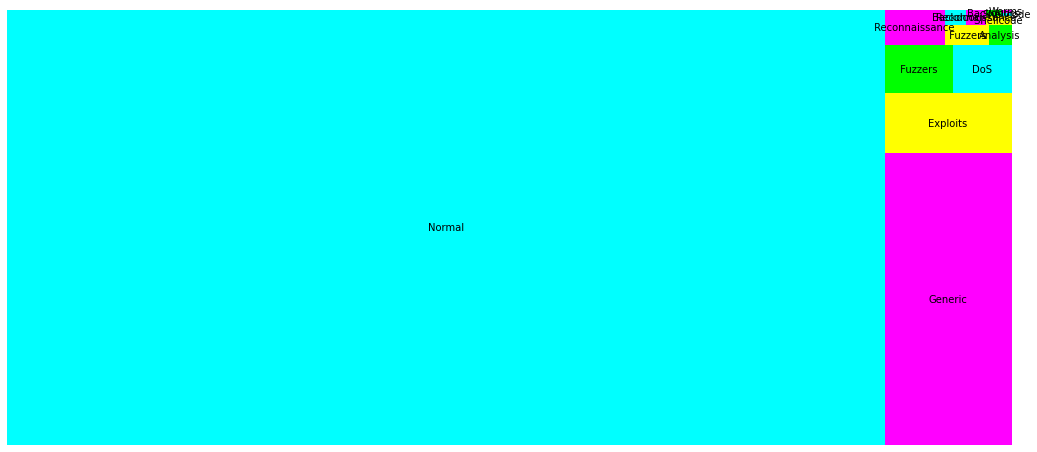

In [18]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(18,8)
squarify.plot(label=ac,sizes=an, color = ["cyan","magenta","yellow","lime"])
plt.axis("off")
plt.show()

We will now deal with missing data in our data. We will check which columns have missing values and then deal with each accordingly by filling NA values with a 0 as this seems to be the easiest course of action.

In [19]:
l = []
colnames = df.columns

for name in colnames:
    if df[name].isnull().values.any():
        l.append(name)
        
print('The columns with missing values in them are: ' + str(l))

The columns with missing values in them are: ['count_flw_http_mthd', 'is_ftp_login']


In addition to the above thanks to analysis by others in the group we noticed that the `count_ftp_cmd` column is also missing data but not as NaN values, instead these missing values are blank " " single spaces so we'll include this column in our processing even though to python it doesn't look like it has any missing data.

In [20]:
print("percentage of missing data in count_flw_http_mthd column:" + str(df["count_flw_http_mthd"].isnull().sum()*100/len(df)))
print("percentage of missing data in is_ftp_login column:" + str(df["is_ftp_login"].isnull().sum()*100/len(df)))
print("percentage of missing data in count_ftp_cmd column:" + str(df["count_ftp_cmd"].isnull().sum()*100/len(df)))

percentage of missing data in count_flw_http_mthd column:53.07559269572571
percentage of missing data in is_ftp_login column:56.29340716923742
percentage of missing data in count_ftp_cmd column:0.0


In [21]:
df = df.fillna(0)
print("percentage of missing data in count_flw_http_mthd column:" + str(df["count_flw_http_mthd"].isnull().sum()*100/len(df)))
print("percentage of missing data in is_ftp_login column:" + str(df["is_ftp_login"].isnull().sum()*100/len(df)))
print("percentage of missing data in count_ftp_cmd column:" + str(df["count_ftp_cmd"].isnull().sum()*100/len(df)))

percentage of missing data in count_flw_http_mthd column:0.0
percentage of missing data in is_ftp_login column:0.0
percentage of missing data in count_ftp_cmd column:0.0


As `count_ftp_cmd` is numeric data, we apply the panda function `pd.to_numeric` with the `errors="coerce"` parameter which will coerce the blank spaces (which count as strings) into NaN values, which will show when we use the same functions we've been using again.

In [22]:
df['count_ftp_cmd'] = df['count_ftp_cmd'].apply(pd.to_numeric,errors="coerce")
print("percentage of missing data in count_flw_http_mthd column:" + str(df["count_flw_http_mthd"].isnull().sum()*100/len(df)))
print("percentage of missing data in is_ftp_login column:" + str(df["is_ftp_login"].isnull().sum()*100/len(df)))
print("percentage of missing data in count_ftp_cmd column:" + str(df["count_ftp_cmd"].isnull().sum()*100/len(df)))

percentage of missing data in count_flw_http_mthd column:0.0
percentage of missing data in is_ftp_login column:0.0
percentage of missing data in count_ftp_cmd column:56.29340716923742


We fill the NA's with 0 again.

In [23]:
df = df.fillna(0)
print("percentage of missing data in count_flw_http_mthd column:" + str(df["count_flw_http_mthd"].isnull().sum()*100/len(df)))
print("percentage of missing data in is_ftp_login column:" + str(df["is_ftp_login"].isnull().sum()*100/len(df)))
print("percentage of missing data in count_ftp_cmd column:" + str(df["count_ftp_cmd"].isnull().sum()*100/len(df)))

percentage of missing data in count_flw_http_mthd column:0.0
percentage of missing data in is_ftp_login column:0.0
percentage of missing data in count_ftp_cmd column:0.0


Now we will deal with the problems we noticed earlier in that some of the attack categories were duplicated due to the structure of their string. Looking back at our earlier findings we write the following block of code to fix this problem. And will see we no longer have any duplicates, and we can repeat our visualisation.

In [24]:
df['attack_cat'] = df['attack_cat'].map({'Normal': 'Normal', 'Exploits': 'Exploits', ' Fuzzers ': 'Fuzzers', 'DoS': 'DoS',
                                          ' Reconnaissance ': 'Reconnaissance', ' Fuzzers': 'Fuzzers', 'Analysis': 'Analysis',
                                         'Backdoor': 'Backdoor', 'Reconnaissance': 'Reconnaissance',  ' Shellcode ': 'Shellcode',
                                         'Backdoors': 'Backdoor', 'Shellcode': 'Shellcode',  'Worms': 'Worms', 'Generic': 'Generic'})
df.groupby('attack_cat').size()

attack_cat
Analysis             2677
Backdoor             2329
DoS                 16353
Exploits            44525
Fuzzers             24246
Generic            215481
Normal            2218764
Reconnaissance      13987
Shellcode            1511
Worms                 174
dtype: int64

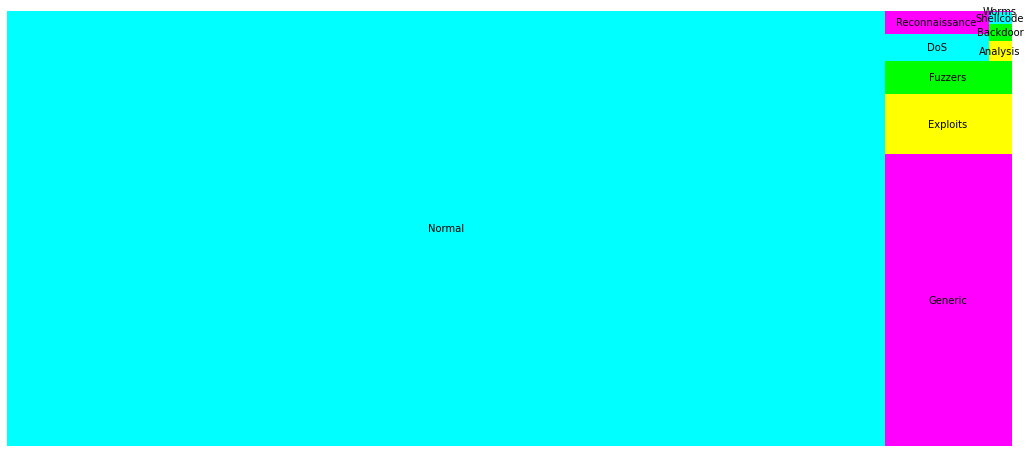

In [25]:
attackcount = pd.DataFrame(df['attack_cat'].value_counts())
ac = []
for i in attackcount.index:
    ac.append(i)
an = attackcount["attack_cat"].tolist()
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(18,8)
squarify.plot(label=ac,sizes=an, color = ["cyan","magenta","yellow","lime"])
plt.axis("off")
plt.show()

For use in neural networks prediction we want our data to be numeric however when looking at our data types in the next block we see there is all kinds of different types of data present. We will use a dictionary mapping in order to convert this data into something that is more appropriate. (We also drop the Label column here as it is not useful)

In [26]:
df.dtypes

source_ip                     object
source_port                   object
dest_ip                       object
dest_port                     object
proto                         object
state                         object
duration                     float64
source_bytes                   int64
dest_bytes                     int64
source_ttl                     int64
dest_ttl                       int64
source_loss                    int64
dest_loss                      int64
service                       object
source_load                  float64
dest_load                    float64
source_pkts                    int64
dest_pkts                      int64
source_TP_win                  int64
dest_TP_win                    int64
source_tcp_bn                  int64
dest_tcp_bn                    int64
source_mean_sz                 int64
dest_mean_sz                   int64
trans_depth                    int64
res_bdy_len                    int64
source_jitter                float64
d

In [27]:
df = df.drop('Label',axis=1)
df_source_ip = pd.DataFrame(df['source_ip'])
df_source_port = pd.DataFrame(df['source_port'])
df_dest_ip = pd.DataFrame(df['dest_ip'])
df_dest_port = pd.DataFrame(df['dest_port'])
df_proto = pd.DataFrame(df['proto'])
df_state = pd.DataFrame(df['state'])
df_service = pd.DataFrame(df['service'])
df_count_ftp_cmd = pd.DataFrame(df['count_ftp_cmd'])
df_attack_cat = pd.DataFrame(df['attack_cat'])

# we now create dictionaries to allow us to map onto the data frame

sips = df.source_ip.unique()
sip_dict = dict(zip(sips,range(len(sips))))

sp = df.source_port.unique()
sp_dict = dict(zip(sp,range(len(sp))))
               
dips = df.dest_ip.unique()
dip_dict = dict(zip(dips,range(len(dips))))

dp = df.dest_port.unique()
dp_dict = dict(zip(dp,range(len(dp))))

p = df.proto.unique()
p_dict = dict(zip(p,range(len(p))))

states = df.state.unique()
state_dict = dict(zip(states,range(len(states))))

services = df.service.unique()
service_dict = dict(zip(services,range(len(services))))

cfc = df.count_ftp_cmd.unique()
cfc_dict = dict(zip(cfc,range(len(cfc))))

ac = df.attack_cat.unique()
ac_dict = dict(zip(ac,range(len(ac))))

df['source_ip_int'] = df['source_ip'].map(sip_dict)
df['source_port_int'] = df['source_port'].map(sp_dict)
df['dest_ip_int'] = df['dest_ip'].map(dip_dict)
df['dest_port_int'] = df['dest_port'].map(dp_dict)
df['proto_int'] = df['proto'].map(p_dict)
df['state_int'] = df['state'].map(state_dict)
df['service_int'] = df['service'].map(service_dict)
df['count_ftp_cmd_int'] = df['count_ftp_cmd'].map(cfc_dict)
df['attack_cat_int'] = df['attack_cat'].map(ac_dict)

df = df.drop('source_ip',axis=1)
df = df.drop('source_port',axis=1)
df = df.drop('dest_ip',axis=1)
df = df.drop('dest_port',axis=1)
df = df.drop('proto',axis=1)
df = df.drop('state',axis=1)
df = df.drop('service',axis=1)
df = df.drop('count_ftp_cmd',axis=1)
df = df.drop('attack_cat',axis=1)

df.dtypes

duration                     float64
source_bytes                   int64
dest_bytes                     int64
source_ttl                     int64
dest_ttl                       int64
source_loss                    int64
dest_loss                      int64
source_load                  float64
dest_load                    float64
source_pkts                    int64
dest_pkts                      int64
source_TP_win                  int64
dest_TP_win                    int64
source_tcp_bn                  int64
dest_tcp_bn                    int64
source_mean_sz                 int64
dest_mean_sz                   int64
trans_depth                    int64
res_bdy_len                    int64
source_jitter                float64
dest_jitter                  float64
start_time                     int64
last_time                      int64
source_int_pk_time           float64
dest_int_pk_time             float64
tcp_rtt                      float64
synack                       float64
a

Just in case we'll once again check for missingess.

In [28]:
l = []
colnames = df.columns

for name in colnames:
    if df[name].isnull().values.any():
        l.append(name)
        
print('The columns with na/nan values in them are: ' + str(l))

The columns with na/nan values in them are: []


It is good practice to scale our data so that certain features do not heavily weight the learning process. We will also seperate out our `attack_cat` column as this will be what we are going to predict with our neural network.

In [29]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def preprocess(data,scaling=None):
    data = data.astype(np.float)
    if(scaling == None):
        scaling = StandardScaler()
        datat=scaling.fit_transform(data)
    else:
        datat=scaling.transform(data)
    return(datat,scaling)

In [30]:
Y = df['attack_cat_int']
X = df.drop('attack_cat_int',axis=1)

In [31]:
X_scaled, scaling = preprocess(X.values)
print(X.shape)
print(X_scaled.shape)
print(Y.shape)

(2540047, 47)
(2540047, 47)
(2540047,)


We now split our data into testing and training data.

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.1, random_state = 10)

The next 2 documents are the python scripts that I submitted to the HPC, they repeats a lot of what has happened in this document and then proceed to define Neural Networks model for classification. I will address these models in detail in the document after but the basics are that each one has different layer configurations.

### References

[So much use of the SLURM documentation in order to understand the available function on the HPC.](https://slurm.schedmd.com/documentation.html)

[DST HPC documentation was a good start for using the HPC.](https://dsbristol.github.io/dst/coursebook/appendix5-bluecrystal.html)

[BlueCrystal Phase 4 Documentation.](https://www.acrc.bris.ac.uk/protected/bc4-docs/index.html)

[Tensorflow tutorial for classification.](https://www.tensorflow.org/tutorials/structured_data/feature_columns)